# 第7章 機械学習の前処理を行う10本ノック

In [1]:
ENV["LINES"] = 10

10

In [18]:
using DataFrames
using DataFramesMeta
using CSV
using MLJ
using Gadfly
using HypothesisTests
using Pingouin

## 81

In [3]:
dataset_df = CSV.read(download("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"), DataFrame)

Row,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
,Int64,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,String15?,String3,Bool
1,0,3,male,22.0,1,0,7.25,S,Third,man,true,missing,Southampton,no,false
2,1,1,female,38.0,1,0,71.2833,C,First,woman,false,C,Cherbourg,yes,false
3,1,3,female,26.0,0,0,7.925,S,Third,woman,false,missing,Southampton,yes,true
4,1,1,female,35.0,1,0,53.1,S,First,woman,false,C,Southampton,yes,false
5,0,3,male,35.0,0,0,8.05,S,Third,man,true,missing,Southampton,no,true
6,0,3,male,missing,0,0,8.4583,Q,Third,man,true,missing,Queenstown,no,true
7,0,1,male,54.0,0,0,51.8625,S,First,man,true,E,Southampton,no,true
8,0,3,male,2.0,3,1,21.075,S,Third,child,false,missing,Southampton,no,false
9,1,3,female,27.0,0,2,11.1333,S,Third,woman,false,missing,Southampton,yes,false


In [4]:
label = dataset_df.survived
dataset2_df = select(dataset_df, Not(:survived))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,String15?,String3,Bool
1,3,male,22.0,1,0,7.25,S,Third,man,true,missing,Southampton,no,false
2,1,female,38.0,1,0,71.2833,C,First,woman,false,C,Cherbourg,yes,false
3,3,female,26.0,0,0,7.925,S,Third,woman,false,missing,Southampton,yes,true
4,1,female,35.0,1,0,53.1,S,First,woman,false,C,Southampton,yes,false
5,3,male,35.0,0,0,8.05,S,Third,man,true,missing,Southampton,no,true
6,3,male,missing,0,0,8.4583,Q,Third,man,true,missing,Queenstown,no,true
7,1,male,54.0,0,0,51.8625,S,First,man,true,E,Southampton,no,true
8,3,male,2.0,3,1,21.075,S,Third,child,false,missing,Southampton,no,false
9,3,female,27.0,0,2,11.1333,S,Third,woman,false,missing,Southampton,yes,false


## 82

In [5]:
(train_df, test_df), (train_label, test_label) = partition((dataset2_df, label), 0.7; rng=1234, stratify=label, multi=true)

((623×14 DataFrame
 Row │ pclass  sex      age        sibsp  parch  fare     embarked  class    w ⋯
     │ Int64   String7  Float64?   Int64  Int64  Float64  String1?  String7  S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      2  male          51.0      0      0  12.525   S         Second   m ⋯
  ⋮  │   ⋮        ⋮         ⋮        ⋮      ⋮       ⋮        ⋮         ⋮       ⋱
                                                  6 columns and 622 rows omitted, 268×14 DataFrame
 Row │ pclass  sex      age        sibsp  parch  fare     embarked  class    w ⋯
     │ Int64   String7  Float64?   Int64  Int64  Float64  String1?  String7  S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1  female        24.0      0      0  83.1583  C         First    w ⋯
  ⋮  │   ⋮        ⋮         ⋮        ⋮      ⋮       ⋮        ⋮         ⋮       ⋱
                                                  6 columns and 267 rows

## 83

In [6]:
select!(train_df, Not([:embark_town, :alive]))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,Bool
1,2,male,51.0,0,0,12.525,S,Second,man,true,missing,true
2,3,male,28.0,0,0,22.525,S,Third,man,true,missing,true
3,3,female,13.0,0,0,7.2292,C,Third,child,false,missing,true
4,3,male,missing,0,0,8.05,S,Third,man,true,missing,true
5,3,male,missing,2,0,21.6792,C,Third,man,true,missing,false
6,2,male,59.0,0,0,13.5,S,Second,man,true,missing,true
7,3,male,20.0,0,0,7.8542,S,Third,man,true,missing,true
8,1,male,49.0,1,1,110.883,C,First,man,true,C,false
9,3,male,21.0,0,0,8.05,S,Third,man,true,missing,true


In [7]:
ux = unique(train_df.sex); DataFrames.transform(train_df, @. :sex => ByRow(isequal(ux)) .=> Symbol(:sex_, ux))

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone,sex_male,sex_female
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,String7,String7,Bool,String1?,Bool,Bool,Bool
1,2,male,51.0,0,0,12.525,S,Second,man,true,missing,true,true,false
2,3,male,28.0,0,0,22.525,S,Third,man,true,missing,true,true,false
3,3,female,13.0,0,0,7.2292,C,Third,child,false,missing,true,false,true
4,3,male,missing,0,0,8.05,S,Third,man,true,missing,true,true,false
5,3,male,missing,2,0,21.6792,C,Third,man,true,missing,false,true,false
6,2,male,59.0,0,0,13.5,S,Second,man,true,missing,true,true,false
7,3,male,20.0,0,0,7.8542,S,Third,man,true,missing,true,true,false
8,1,male,49.0,1,1,110.883,C,First,man,true,C,false,true,false
9,3,male,21.0,0,0,8.05,S,Third,man,true,missing,true,true,false


In [8]:
unique_class = unique(train_df.class)
unique_class_d = Dict(zip(unique_class, 1:length(unique_class)))
DataFrames.transform(train_df, :class => ByRow(x -> unique_class_d[x]) => :class)

Row,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
,Int64,String7,Float64?,Int64,Int64,Float64,String1?,Int64,String7,Bool,String1?,Bool
1,2,male,51.0,0,0,12.525,S,1,man,true,missing,true
2,3,male,28.0,0,0,22.525,S,2,man,true,missing,true
3,3,female,13.0,0,0,7.2292,C,2,child,false,missing,true
4,3,male,missing,0,0,8.05,S,2,man,true,missing,true
5,3,male,missing,2,0,21.6792,C,2,man,true,missing,false
6,2,male,59.0,0,0,13.5,S,1,man,true,missing,true
7,3,male,20.0,0,0,7.8542,S,2,man,true,missing,true
8,1,male,49.0,1,1,110.883,C,3,man,true,C,false
9,3,male,21.0,0,0,8.05,S,2,man,true,missing,true


In [9]:
function delete_column(df, column_l)
    available_column_l = []
    for column_i in column_l
        if column_i in names(df)
            append!(column_i)
        end
    end
    if length(available_column_l)
        return df
    end
    return select(df, Not(available_column_l))
end
function get_dummies(df)
    column_l = names(train_df, Union{AbstractString, Missing})
    column_l = vcat(column_l, "pclass")
    for column_i in column_l
        unique_l = unique(df[!, Symbol(column_i)])
        df = DataFrames.transform(df, @. Symbol(column_i) => ByRow(isequal(unique_l)) .=> Symbol("$(column_i)_", unique_l))
        select!(df, Not(column_i))
    end
    return df
end

get_dummies (generic function with 1 method)

In [10]:
train_df = get_dummies(train_df)

Row,age,sibsp,parch,fare,adult_male,alone,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,embarked_missing,class_Second,class_Third,class_First,who_man,who_child,who_woman,deck_missing,deck_C,deck_A,deck_B,deck_D,deck_E,deck_F,deck_G,pclass_2,pclass_3,pclass_1
,Float64?,Int64,Int64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,51.0,0,0,12.525,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false
2,28.0,0,0,22.525,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
3,13.0,0,0,7.2292,false,true,false,true,false,true,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,true,false
4,missing,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
5,missing,2,0,21.6792,true,false,true,false,false,true,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
6,59.0,0,0,13.5,true,true,true,false,true,false,false,false,true,false,false,true,false,false,true,false,false,false,false,false,false,false,true,false,false
7,20.0,0,0,7.8542,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false
8,49.0,1,1,110.883,true,false,true,false,false,true,false,false,false,false,true,true,false,false,false,true,false,false,false,false,false,false,false,false,true
9,21.0,0,0,8.05,true,true,true,false,true,false,false,false,false,true,false,true,false,false,true,false,false,false,false,false,false,false,false,true,false


In [11]:
iqr_df = @chain train_df begin
    describe(:q25, :q75)
    @transform begin
        @astable begin
            :iqr = :q75 - :q25
            :mx = :q75 + 1.5 * :iqr
            :mn = :q25 - 1.5 * :iqr
        end
    end
    @select(:variable, :mx, :mn)
end

Row,variable,mx,mn
,Symbol,Float64,Float64
1,age,65.0,-7.0
2,sibsp,2.5,-1.5
3,parch,0.0,0.0
4,fare,66.3,-27.1
5,adult_male,2.5,-1.5
6,alone,2.5,-1.5
7,sex_male,2.5,-1.5
8,sex_female,2.5,-1.5
9,embarked_S,1.75,-0.25


In [12]:
for column_i in names(train_df)
    idx = iqr_df.variable .== :age
    # minimum
    smn = sum(skipmissing(train_df[!, Symbol(column_i)] .<= iqr_df[idx, :mn]))
    # max
    smx = sum(skipmissing(train_df[!, Symbol(column_i)] .>= iqr_df[idx, :mx]))
    println(column_i, " ", smn + smx)
end

age 9


sibsp 0
parch 0


fare 84


adult_male 0
alone 0


sex_male 0
sex_female 0
embarked_S 0
embarked_C 0
embarked_Q 0
embarked_missing 0
class_Second 0
class_Third 0
class_First 0
who_man 0
who_child 0
who_woman 0
deck_missing 0
deck_C 0
deck_A 0
deck_B 0
deck_D 0
deck_E 0
deck_F 0
deck_G 0
pclass_2 0
pclass_3 0
pclass_1 0


## 85

In [13]:
describe(train_df, :all)

Row,variable,mean,std,min,q25,median,q75,max,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Nothing,Int64,Int64,Int64,Real,Real,Type
1,age,29.783,14.6713,0.67,20.0,28.0,38.0,80.0,,84,115,508,51.0,18.0,"Union{Missing, Float64}"
2,sibsp,0.545746,1.14007,0,0.0,0.0,1.0,8,,7,0,623,0,1,Int64
3,parch,0.372392,0.795491,0,0.0,0.0,0.0,5,,6,0,623,0,0,Int64
4,fare,32.281,48.7217,0.0,7.925,14.4542,31.275,512.329,,214,0,623,12.525,6.4958,Float64
5,adult_male,0.605136,0.489214,false,0.0,1.0,1.0,true,,2,0,623,true,true,Bool
6,alone,0.597111,0.490873,false,0.0,1.0,1.0,true,,2,0,623,true,false,Bool
7,sex_male,0.651685,0.476819,false,0.0,1.0,1.0,true,,2,0,623,true,true,Bool
8,sex_female,0.348315,0.476819,false,0.0,0.0,1.0,true,,2,0,623,false,false,Bool
9,embarked_S,0.749599,0.433592,false,0.5,1.0,1.0,true,,2,0,623,true,true,Bool


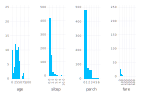

In [14]:
p1 = plot(train_df, x=:age, Geom.histogram)
p2 = plot(train_df, x=:sibsp, Geom.histogram)
p3 = plot(train_df, x=:parch, Geom.histogram)
p4 = plot(train_df, x=:fare, Geom.histogram)
hstack(p1, p2, p3, p4)

In [15]:
x = [count(==(i), skipmissing(train_df.age)) for i in 0:60]

61-element Vector{Int64}:
 0
 4
 6
 ⋮
 2
 3

In [16]:
ChisqTest(x)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934  …  0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934, 0.0163934]
    point estimate:          [0.0, 0.00843882, 0.0126582, 0.00843882, 0.0147679, 0.00632911, 0.00632911, 0.00421941, 0.00421941, 0.0147679  …  0.0126582, 0.0105485, 0.0021097, 0.0126582, 0.0021097, 0.00421941, 0.00421941, 0.00843882, 0.00421941, 0.00632911]
    95% confidence interval: [(0.0, 0.02613), (0.0, 0.03457), (0.0, 0.03879), (0.0, 0.03457), (0.0, 0.0409), (0.0, 0.03246), (0.0, 0.03246), (0.0, 0.03035), (0.0, 0.03035), (0.0, 0.0409)  …  (0.0, 0.03879), (0.0, 0.03668), (0.0, 0.02824), (0.0, 0.03879), (0.0, 0.02824), (0.0, 0.03035), (0.0, 0.03035), (0.0, 0.03457), (0.0, 0.03035), (0.0, 0.03246)]

Test summa

In [19]:
normality(x)

Row,W,pval,normal
,Float64,Float64,Bool
1,0.921539,0.000794472,false


In [20]:
for symbol_i in [:age, :sibsp, :parch, :fare]
    data = collect(skipmissing(train_df[!, symbol_i]))
    min, max = minmax(data)
    x = [count(==(i), data for i in min:60]
end

In [22]:
typeof(p1)

Plot

In [29]:
typeof(p1)

Plot

In [34]:
propertynames(p1)

(:layers, :data_source, :data, :scales, :statistics, :coord, :guides, :theme, :mapping)

In [41]:
p1.layers

1-element Vector{Layer}:
 Layer(623×29 DataFrame
 Row │ age        sibsp  parch  fare     adult_male  alone  sex_male  sex_fema ⋯
     │ Float64?   Int64  Int64  Float64  Bool        Bool   Bool      Bool     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      51.0      0      0  12.525         true   true      true       fal ⋯
  ⋮  │     ⋮        ⋮      ⋮       ⋮         ⋮         ⋮       ⋮          ⋮    ⋱
                                                 22 columns and 622 rows omitted, Dict{Symbol, Any}(:x => :age), Gadfly.StatisticElement[], Gadfly.Geom.BarGeometry(:stack, :vertical, Gadfly.Stat.HistogramStatistic(3, 150, :stack, :vertical, false, NamedTuple()), Symbol("")), nothing, 0)